# Quora Question Pairs

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train.shape)
print(test.shape)

(404290, 6)
(3563475, 3)


In [4]:
train.sample()

,id,qid1,qid2,question1,question2,is_duplicate
201860,201860,303980,303981,How heavy is a full grown elephant? How is thi...,How heavy is a full grown elephant?,1


In [5]:
test.sample()

,test_id,question1,question2
1365233,1365233,What anarchy the most chaotic thing in the world?,Which is the most mysterious thing sion's in t...


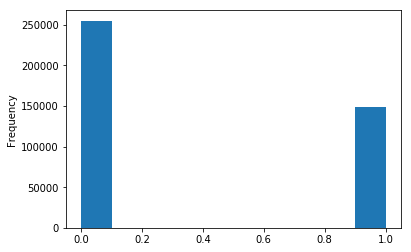

In [6]:
train['is_duplicate'].plot.hist();

In [7]:
percent = train['is_duplicate'].mean()*100
print('The percentage of duplicate in train set is {0:.4g}%'.format(percent))

The percentage of duplicate in train set is 36.92%


In [7]:
train_qs = pd.Series(train['question1'].tolist()+train['question2'].tolist()).astype(str)
train_qs.dtypes

dtype('O')

In [9]:
from collections import Counter
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)

In [10]:
counts.most_common(20)

[('the', 376234),
 ('what', 310963),
 ('is', 268849),
 ('how', 219019),
 ('i', 213185),
 ('a', 210233),
 ('to', 204067),
 ('in', 194724),
 ('of', 158912),
 ('do', 154720),
 ('are', 145405),
 ('and', 132755),
 ('can', 113819),
 ('for', 101512),
 ('you', 84648),
 ('why', 75548),
 ('my', 70759),
 ('best', 69692),
 ('it', 60806),
 ('on', 59407)]

# Tokenization and stopwords removal

In [4]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess #text processing

In [5]:
sentences = train_qs.tolist()
sentences = filter(None, sentences) # remove empty strings
#sentences = list(map(remove_stopwords,sentences)) #clean text 
sentences = list(map(simple_preprocess,sentences)) #clean text 

In [6]:
stoplist = set('for a of the and to in on it is by'.split())
sentences = [[word for word in sentence if word not in stoplist]
          for sentence in sentences]

# Stemming

In [14]:
from nltk.stem.snowball import SnowballStemmer 
snowball = SnowballStemmer("english")
stem_tokens = []

for sentence in sentences:
    s = []
    for word in sentence:
        s.append(snowball.stem(word))
    stem_tokens.append(s)

In [7]:
import pickle
#pickle.dump(stem_tokens, open('stem_tokens.txt','wb'))
stem_tokens = pickle.load(open('stem_tokens.txt','rb'))

# Lemmatization

In [15]:
from nltk.corpus import wordnet as wn
import nltk

def get_wn_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return ''

In [16]:
sentence_pos = [nltk.pos_tag(sentence) for sentence in sentences]

In [17]:
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()
lemma_tokens = []

for sentence in sentence_pos:
    s = []
    for pair in sentence:
        if  get_wn_pos(pair[1]) != '':
            s.append(wnl.lemmatize(pair[0], get_wn_pos(pair[1])))
        else:
            s.append(wnl.lemmatize(pair[0]))
    lemma_tokens.append(s)

In [8]:
#pickle.dump(lemma_tokens, open('lemma_tokens.txt','wb'))
lemma_tokens = pickle.load(open('lemma_tokens.txt','rb'))

# TF-IDF Model

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity

vectorize = TfidfVectorizer()
vect_word = TfidfVectorizer(lowercase=True,analyzer='word',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(lowercase=True,analyzer='char',ngram_range=(3,6),dtype=np.float32)
tfidf_matrix = vectorizer.fit_transform(train_qs)
#tfidf_word_matrix = vect_word.fit_transform(train_qs)
#tfidf_char_matrix = vect_char.fit_transform(train_qs)

In [37]:
tfidf_word_matrix.shape

(808580, 2825037)

In [38]:
tfidf_char_matrix.shape

(808580, 2539587)

In [ ]:
import time
tfidf_pred = []
start_time = time.time()
for i in range(404290):
    score = cosine_similarity(tfidf_matrix[i], tfidf_matrix[404290+i])
    tfidf_pred.append(score[0][0])
print("--- %s seconds ---" % (time.time() - start_time))

In [55]:
import pickle
#pickle.dump(tfidf_matrix, open('tfidf_matrix.txt','wb'))
#pickle.dump(tfidf_word_matrix, open('tfidf_word_matrix.txt','wb'))
#pickle.dump(tfidf_char_matrix, open('tfidf_char_matrix.txt','wb'))
pickle.dump(tfidf_pred, open('tfidf_pred.txt','wb'))
#tfidf_matrix = pickle.load(open('tfidf_matrix.txt','rb'))
#tfidf_pred = pickle.load(open('tfidf_pred.txt','rb'))
#tfidf_word_matrix = pickle.load(open('tfidf_word_matrix.txt','rb'))
#tfidf_char_matrix = pickle.load(open('tfidf_char_matrix.txt','rb'))

In [49]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
print('TF-IDF log_loss:', log_loss(train['is_duplicate'], tfidf_pred))
print('TF-IDF accuracy:', accuracy_score(train['is_duplicate'], 
                                         list(map(lambda x: round(x), tfidf_pred))))

TF-IDF log_loss: 12.816658725868669
TF-IDF accuracy: 0.6289198347720696


# Logistic Regression on TF-IDF

In [45]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
X = hstack([tfidf_word_matrix[0:404290], tfidf_char_matrix[0:404290], 
            tfidf_word_matrix[404290:], tfidf_char_matrix[404290:]])
y = train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.25)

In [46]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
logistic_pred = clf.predict(X_valid)
logistic_pre_proba = clf.predict_proba(X_valid)
print('Logistic Regression log_loss:', log_loss(y_valid, logistic_pre_proba))
print('Logistic Regression accuracy:', accuracy_score(y_valid, logistic_pred))

Logistic Regression log_loss: 0.5033287322410525
Logistic Regression accuracy: 0.7597973741751012


# Doc2Vec Model

In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]

In [40]:
d2v_model = Doc2Vec(window=3, min_count=2, workers=4, alpha=0.025, min_alpha=0.025)
d2v_model.build_vocab(documents)

In [41]:
import time
start_time = time.time()
for epoch in range(10):
    d2v_model.train(documents, total_examples=len(documents), epochs=1)
    d2v_model.alpha -= 0.002                # decrease the learning rate
    d2v_model.min_alpha = model.alpha       # fix the learning rate, no decay
print("--- %s seconds ---" % (time.time() - start_time))

--- 567.3281860351562 seconds ---


In [42]:
d2v_model.save('doc2vec.model')
d2v_model = Doc2Vec.load('doc2vec.model')

In [43]:
d2v_model.docvecs.most_similar(positive=[model.infer_vector(sentences[0])],topn=5)

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(0, 0.563169002532959),
 (602108, 0.5296576023101807),
 (108486, 0.5231451392173767),
 (404290, 0.5165294408798218),
 (739041, 0.5136462450027466)]

In [44]:
d2v_model.docvecs.n_similarity([0], [404290])

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.89288795

In [45]:
doc2vec_pred = []
for i in range(404290):
    score = d2v_model.docvecs.similarity(i, 404290+i)
    doc2vec_pred.append(score)

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [311]:
print('Doc2Vec log_loss:', log_loss(train['is_duplicate'], doc2vec_pred))
print('Doc2Vec accuracy:', accuracy_score(train['is_duplicate'], list(map(lambda x: round(x), doc2vec_pred))))

Doc2Vec AUC: 0.7028003809431244
Doc2Vec accuracy: 0.6583492047787479


# Word2Vec Model

In [314]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences, window=3, min_count=2, workers=4, alpha=0.025, min_alpha=0.025)

In [315]:
import time
start_time = time.time()
for epoch in range(10):
    w2v_model.train(sentences, total_examples=len(sentences), epochs=1)
    w2v_model.alpha -= 0.002                # decrease the learning rate
    w2v_model.min_alpha = w2v_model.alpha       # fix the learning rate, no decay
print("--- %s seconds ---" % (time.time() - start_time))

--- 64.77591300010681 seconds ---


In [ ]:
#w2v_model.save('word2vec.zmodel.sav')
w2v_model = Word2Vec.load('word2vec.model')

In [316]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in index2word_set:
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [ ]:
len(w2v_model.wv['india'])

In [317]:
word2vec_pred = []
num_features = 100 
for i in range(404290):
    q1_avg_vector = avg_sentence_vector(sentences[0+i], w2v_model, num_features, 
                                        w2v_model.wv.vocab).reshape(1,-1)
    q2_avg_vector = avg_sentence_vector(sentences[404290+i], w2v_model, num_features, 
                                        w2v_model.wv.vocab).reshape(1,-1)
    score = cosine_similarity(q1_avg_vector,q2_avg_vector)
    word2vec_pred.append(score[0][0])

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [318]:
print('Word2Vec log_loss:', log_loss(train['is_duplicate'], word2vec_pred))
print('Word2Vec accuracy:', accuracy_score(train['is_duplicate'], list(map(lambda x: round(x), word2vec_pred))))
# AUC: lemma > token > stem

Word2Vec AUC: 0.7248271912128748
Word2Vec accuracy: 0.5244700586212867
